<a href="https://colab.research.google.com/github/geraldine-ht/NLP/blob/master/NLP_project_Joly_Houatra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Projet NLP - ENSAE 2019/2020

Houatra Géraldine - Joly Benjamin

Dans ce notebook, nous voulons réaliser une classification de sentiments sur des commentaires d'articles du New York Times. Nous voulons voir la corrélation entre le sentiment porté par un titre d'article et les sentiments véhiculés par les commentaires associés.

Schéma illustrant la réalisation de notre projet à travers ce Colab (en bleu le nettoyage, en orange la labellisation et en vert le modèle BERT :

![](https://drive.google.com/uc?id=1F4JU351gSgfSl96kfoqszGIVlLzqlQFJ)

# Modules et Bibliothèques

In [0]:
# Modules et Bibliothèques utilisées

import numpy as np
import pandas as pd
from math import log
import matplotlib.pyplot as plt
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
from scipy import stats
from pandas import plotting
from sklearn.model_selection import KFold,train_test_split
from sklearn import model_selection
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.display import Math,display, HTML, Image, Latex, SVG

%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importation des bases de données

On dispose de 3 bases de données :

*   Trump_Articles : contient les titres et l'ID des articles traitant de Trump en mars 2018
*   Trump_Comments : contient les commentaires et l'ID de l'article en lien de mars 2018, concernant les article portant sur Trump
*   Comment_March_2018 : contient les commentaires et l'ID de l'article en lien de mars 2018, concernant les article NE portant PAS sur Trump



In [0]:
# telechargement de la BDD "Articles_Trump"
!wget -O Trump_Articles.csv https://drive.google.com/uc?id=1EEPVrd_XV6lcS7zwyjKJ2t7r056SU92B
Trump_Articles = pd.read_csv('/content/Trump_Articles.csv', delimiter=';')
Trump_Articles = Trump_Articles[['headline','articleID']]
Trump_Articles.head()

--2020-04-12 12:24:38--  https://drive.google.com/uc?id=1EEPVrd_XV6lcS7zwyjKJ2t7r056SU92B
Resolving drive.google.com (drive.google.com)... 172.253.118.101, 172.253.118.138, 172.253.118.113, ...
Connecting to drive.google.com (drive.google.com)|172.253.118.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/45vicht2fhvnsl72o1uq9si0qqpoak0g/1586694225000/08369696792954202122/*/1EEPVrd_XV6lcS7zwyjKJ2t7r056SU92B [following]
--2020-04-12 12:24:39--  https://doc-10-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/45vicht2fhvnsl72o1uq9si0qqpoak0g/1586694225000/08369696792954202122/*/1EEPVrd_XV6lcS7zwyjKJ2t7r056SU92B
Resolving doc-10-94-docs.googleusercontent.com (doc-10-94-docs.googleusercontent.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to doc-10-94-docs.googleusercontent.com (doc-10-94-docs.googleusercontent.com)|1

,headline,articleID
0,G.O.P. Leadership Poised to Topple Obama’s Pi...,58691a5795d0e039260788b9
1,Sprint and Mr. Trump’s Fictional Jobs,586a0d8795d0e039260789b3
2,America Becomes a Stan,586a0d8795d0e039260789b6
3,"Mr. Trump, Bureaucracy Apprentice",586b037e95d0e03926078af5
4,Lessons From the Tea Party,586b10be95d0e03926078b11


In [0]:
# telechargement de la BDD "Comments_Trump" réduite et focalisée sur les commentaire
!wget -O Trump_Comments.csv https://drive.google.com/uc?id=1iXeiDVvTZAbkIff8hWquHtXNw8sRdoLB
Trump_Comments = pd.read_csv('/content/Trump_Comments.csv', delimiter=';')
Trump_Comments.head()

--2020-04-12 12:24:43--  https://drive.google.com/uc?id=1iXeiDVvTZAbkIff8hWquHtXNw8sRdoLB
Resolving drive.google.com (drive.google.com)... 172.253.118.101, 172.253.118.138, 172.253.118.113, ...
Connecting to drive.google.com (drive.google.com)|172.253.118.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gcm9cj0gceenqcteh18eg1ftc10320st/1586694225000/08369696792954202122/*/1iXeiDVvTZAbkIff8hWquHtXNw8sRdoLB [following]
--2020-04-12 12:24:48--  https://doc-0s-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gcm9cj0gceenqcteh18eg1ftc10320st/1586694225000/08369696792954202122/*/1iXeiDVvTZAbkIff8hWquHtXNw8sRdoLB
Resolving doc-0s-94-docs.googleusercontent.com (doc-0s-94-docs.googleusercontent.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to doc-0s-94-docs.googleusercontent.com (doc-0s-94-docs.googleusercontent.com)|1

,commentBody,articleID,userID
0,"Oh, everybody is like that. A good fair honest...",5a9752a2410cf7000162e8ba,65046283
1,Trump will go down as the WORST PRESIDENT IN T...,5a9752a2410cf7000162e8ba,72717423
2,It is hard to imagine Trump as he is and has b...,5a9752a2410cf7000162e8ba,52585988
3,"""None of this is remotely surprising anymore, ...",5a9752a2410cf7000162e8ba,1812066
4,I'm not a doctor or a health professional but ...,5a9752a2410cf7000162e8ba,42087476


In [0]:
# telechargement de la BDD "Comments_March_2018" sans lien avec Trump
!wget -O Comments_March_2018.csv https://drive.google.com/uc?id=13pQuetkRL8MUU-_s61T-jWYp9QYcF0qO
Comments_March_2018 = pd.read_csv('/content/Comments_March_2018.csv', delimiter=';')
Comments_March_2018.head()

--2020-04-12 12:24:53--  https://drive.google.com/uc?id=13pQuetkRL8MUU-_s61T-jWYp9QYcF0qO
Resolving drive.google.com (drive.google.com)... 172.253.118.100, 172.253.118.139, 172.253.118.138, ...
Connecting to drive.google.com (drive.google.com)|172.253.118.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ur46sbug6sju974v1ogid1640a8q9gkr/1586694225000/08369696792954202122/*/13pQuetkRL8MUU-_s61T-jWYp9QYcF0qO [following]
--2020-04-12 12:24:59--  https://doc-08-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ur46sbug6sju974v1ogid1640a8q9gkr/1586694225000/08369696792954202122/*/13pQuetkRL8MUU-_s61T-jWYp9QYcF0qO
Resolving doc-08-94-docs.googleusercontent.com (doc-08-94-docs.googleusercontent.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to doc-08-94-docs.googleusercontent.com (doc-08-94-docs.googleusercontent.com)|1

,commentBody,articleID,userID
0,If the choice is between mining for bitcoin - ...,5a974697410cf7000162e8a4,46903103
1,"<br/>To me, Bitcoin (et al) appears to be an e...",5a974697410cf7000162e8a4,82778
2,Bitcoin is a pyramid scheme backed by nothing ...,5a974697410cf7000162e8a4,3013548
3,What does it cost in energy to dig up and refi...,5a974697410cf7000162e8a4,70245222
4,You forgot to mention stock buybacks.,5a974697410cf7000162e8a4,66424344


# Création de nos ensembles de données

##  Train & Validation

In [0]:
# On extrait n=10 000 commentaires sur Trump pour l'ensemble de Train

Train_Trump = Trump_Comments.sample(n=10000, random_state=1)
Train_Trump

,commentBody,articleID,userID
103106,Oh please build a wall. I think we should actu...,5a9d72fb410cf7000162f090,38611700
76834,The article raises so many issues that I think...,5ab4ff2447de81a901215ff1,2156318
27188,LOL. Repeat. Then sneer. And don't stop.<br/>I...,5aa265b447de81a90120c261,49780703
76416,I would hope she or anyone else who got close ...,5ab4701247de81a901215bec,14429551
7676,This is another short sided decision by a Pres...,5a996d3f410cf7000162ee6d,47124136
...,...,...,...
39255,It is very hard not to think that Tillerson ha...,5aa7c9c147de81a90120e141,79278717
108146,"53% of the white women that voted, voted for t...",5aa5ccab47de81a90120d30c,56936950
111023,Of course the prospect of war is not to be tak...,5aaa40a747de81a901210447,72463355
19838,It is another ploy by Trump to destabilize the...,5aa031e947de81a90120b4de,35477595


In [0]:
# on retire l'ensemble de Train de l'ensemble total pour ne pas les reprendre dans l'ensemble de Test

print('Taille avant :', Trump_Comments.shape[0])
print('Drop des lignes ...')
Trump_Comments = Trump_Comments.drop(Train_Trump.index)
print('Taille après :', Trump_Comments.shape[0])

Taille avant : 124421
Drop des lignes ...
Taille après : 114421


In [0]:
# On extrait n=40 000 commentaires NE portant PAS sur Trump pour l'ensemble de Train

Train_NO_Trump = Comments_March_2018.sample(n=40000, random_state=1)
Train_NO_Trump

,commentBody,articleID,userID
24135,Interesting not one mention of President Trump...,5aa29b1d47de81a90120c47d,73608530
85524,Did people stop using phones when telemarketer...,5abbd90447de81a901218c54,68935216
46375,I think the larger picture is that what happen...,5aabdbf547de81a901211412,1694096
11704,Ironic. I thought we progressives are general...,5a9d563747de81a90120a1b7,54101121
3511,Ethics? What‚Äôs that.,5a9846bf410cf7000162eb4a,60205911
...,...,...,...
79464,I love music. I love listening to music. I lov...,5aba12a547de81a901217c97,59570791
10079,Whenever an area is defined by a technology by...,5a9c6b7f47de81a901209dc9,6374175
19663,I feel like everyone is misinterpreting the de...,5aa0305b47de81a90120b4d2,72822450
67608,A lot of good men have destroyed careers becau...,5ab4c21e47de81a901215ddc,53609548


In [0]:
# On fusionne les deux ensemble de Train pour former notre ensemble de Train final contenant 50 000 commentaires :
# 10 000 commentaires traitant d'un article sur Trump
# 40 000 commentaires traitant d'un article NE portant PAS sur Trump

Train = pd.concat([Train_NO_Trump, Train_Trump], ignore_index=True, sort=False)

In [0]:
# Creation de l'ensemble de Validation de taille 10 000 à partir de l'ensemble de Train

# on shuffle l'ensemble Train puis on extrait l'ensemble de validation
Train = Train.sample(n=Train.shape[0], random_state=1)
Validation = Train.sample(n=10000, random_state=1)
# Actualisation de l'ensemble de Train pour avoir une taille de 40 000
Train = Train.drop(Validation.index)

In [0]:
# On remet tous les ensembles sous forme de pd.DataFrama

# Train
Train = pd.DataFrame(Train)
Train = Train.reset_index(drop=True)

# Validation
Validation = pd.DataFrame(Validation)
Validation = Validation.reset_index(drop=True)

In [0]:
Train.head()

,commentBody,articleID,userID
0,"Joe Biden, please!",5aad639447de81a901211e8b,12883090
1,I left teaching before I got in too deep. The...,5ab842b947de81a9012170d2,45540664
2,Integration psychologically is only possible w...,5abd855c47de81a901219c1c,75948691
3,Love this...and her. <br/><br/>What a relief ...,5aaf7c2147de81a901212679,59977368
4,"""There is an international community that occa...",5ab554d147de81a901216469,56137599


In [0]:
Validation.head()

,commentBody,articleID,userID
0,Why would people who don't have guns want to t...,5aaf86b847de81a9012126a9,82004583
1,"Ben Sasse. Nebraska Republican, is in Trump's ...",5a9d563747de81a90120a1b7,21208144
2,"""the bulletproof private transports preferred ...",5aba19d147de81a901217cba,21694747
3,Reading the comments on here by Times readers ...,5a985b9a410cf7000162eb85,17788919
4,Let's not complicate this. Trump has also told...,5aa1143647de81a90120b853,14956507


##  Tests

On définit deux ensembles de tests : les titres des articles concernant Trump d'un côté, des commentaires sur Trump de l'autre côté.

In [0]:
# On extrait n=2111 (Trump_Articles.shape[0]) titres d'articles sur Trump pour l'ensemble de Test

Test_Trump_articles = Trump_Articles.sample(n=Trump_Articles.shape[0], random_state=1)
Test_Trump_articles = Test_Trump_articles.reset_index(drop=True)
Test_Trump_articles.columns = ['commentBody', 'articleID']
Test_Trump_articles

,commentBody,articleID
0,Meager Support for Blend of Policy in Replace...,58befc877c459f247962dbcb
1,Can This Presidency Be Saved?,589f6ff295d0e02474635d70
2,Pence’s Presidential Pet,5892ec0795d0e0392607e28f
3,Mike Pompeo Works the Hill,5acffed0068401528a2a86e8
4,Trump Sees Trade Loss By Ignoring Key Sector,5aabeb5f47de81a90121150d
...,...,...
2106,The Guardrails Of Democracy,591580a67c459f24986df2f5
2107,The New Study That Shows Trumpcare’s Damage,590a886a7c459f24986dd989
2108,Oh Dear. The Trumps Keep Multiplying.,592fc07c7c459f24986e2c31
2109,Falwell’s New Role Could Aid His Own University,58924a9195d0e0392607e0fa


In [0]:
# On extrait n=5 000 commentaires sur Trump pour l'ensemble de Test

Test_Trump = Trump_Comments.sample(n=5000, random_state=1)
Test_Trump = Test_Trump.reset_index(drop=True)
Test_Trump

,commentBody,articleID,userID
0,"Bartolo -- ""Is there any evidence""<br/><br/>Ye...",5ab9862047de81a901217995,37674938
1,Reagan who didn't smoke advertised cigarettes ...,5ab136a147de81a901213555,62945206
2,"Congress' time to ""wake up soon"" happened long...",5aaf7c1e47de81a901212671,59144840
3,As long as Republicans in Congress allow Trump...,5aac76e847de81a901211a5b,79969624
4,Wow. I definitely won't be watching this show....,5aba502547de81a901217e5f,79070806
...,...,...,...
4995,The article reads as thought the VA merely pro...,5abd6a7647de81a901219b44,41558614
4996,Trump is simply repulsive. He is everything w...,5aa43dbe47de81a90120cd88,23689673
4997,This is a good move. If steel manufacturing di...,5a981947410cf7000162eaa2,68501536
4998,Where is the reasoned and rational use of tari...,5aa031e947de81a90120b4de,56385081


Nous disposons maintenant de 4 ensembles : 2 pour l'apprentissage (Train et Validation) et deux pour les tests (Test_Trump sur les commentaires & Test_Trump_articles pour les titres des articles).

# Nettoyage des données

##  Nettoyage avec fonctions personnelles

In [0]:
# Fonctions pour nettoyer le texte


def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

def remove_br1(tokens):
  tokens = filter(lambda x: x.replace('<', ''), tokens)
  return list(tokens)

def remove_br2(tokens):
  tokens = filter(lambda x: x.replace('br/', ''), tokens)
  return list(tokens)

def remove_br3(tokens):
  tokens = filter(lambda x: x.replace('>', ''), tokens)
  return list(tokens)

def remove_0(tokens):
  tokens = map(lambda x: x.replace('0', ''), tokens)
  return list(tokens)

def remove_1(tokens):
  tokens = map(lambda x: x.replace('1', ''), tokens)
  return list(tokens)

def remove_2(tokens):
  tokens = map(lambda x: x.replace('2', ''), tokens)
  return list(tokens)

def remove_3(tokens):
  tokens = map(lambda x: x.replace('3', ''), tokens)
  return list(tokens)

def remove_4(tokens):
  tokens = map(lambda x: x.replace('4', ''), tokens)
  return list(tokens)

def remove_5(tokens):
  tokens = map(lambda x: x.replace('5', ''), tokens)
  return list(tokens)

def remove_6(tokens):
  tokens = map(lambda x: x.replace('6', ''), tokens)
  return list(tokens)

def remove_7(tokens):
  tokens = map(lambda x: x.replace('7', ''), tokens)
  return list(tokens)

def remove_8(tokens):
  tokens = map(lambda x: x.replace('8', ''), tokens)
  return list(tokens)

def remove_9(tokens):
  tokens = map(lambda x: x.replace('9', ''), tokens)
  return list(tokens)

def remove_percent(tokens):
  tokens = map(lambda x: x.replace('%', ''), tokens)
  return list(tokens)

def remove_special_A(tokens):
  tokens = map(lambda x: x.replace('Ä', ''), tokens)
  return list(tokens)

def remove_special_U_1(tokens):
  tokens = map(lambda x: x.replace('ú', ''), tokens)
  return list(tokens)

def remove_special_U_2(tokens):
  tokens = map(lambda x: x.replace('ù', ''), tokens)
  return list(tokens)

def remove_special_I_1(tokens):
  tokens = map(lambda x: x.replace('ì', ''), tokens)
  return list(tokens)

def remove_special_1(tokens):
  tokens = map(lambda x: x.replace('&', ''), tokens)
  return list(tokens)

def remove_amp(tokens):
  tokens = map(lambda x: x.replace('amp', ''), tokens)
  return list(tokens)

def remove_gt(tokens):
  tokens = map(lambda x: x.replace('gt', ''), tokens)
  return list(tokens)

def remove_lt(tokens):
  tokens = map(lambda x: x.replace('lt', ''), tokens)
  return list(tokens)

def remove_punctuation_1(tokens):
  tokens = map(lambda x: x.replace('-', ''), tokens)
  return list(tokens)



In [0]:
# Usage of Phrases and Phraser from gensim

import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

from tqdm import tqdm

def tokenize_url_hashtags(corpus):
  tokenizer = TreebankWordTokenizer()  
  # Life hack : treebank word tokenizer won't keep html code in one token.
  # To preprocess economics news corpus, use tweettokenizer. 
  tokenized_sentences = []
  tokenized_sentences_2 = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      # cleaning
      tokens = remove_html(tokens)
      tokens = remove_url(tokens)
      tokens = remove_hashtags(tokens)
      tokens = remove_br1(tokens)
      tokens = remove_br2(tokens)
      tokens = remove_br3(tokens)
      tokens = remove_0(tokens)
      tokens = remove_1(tokens)
      tokens = remove_2(tokens)
      tokens = remove_3(tokens)
      tokens = remove_4(tokens)
      tokens = remove_5(tokens)
      tokens = remove_6(tokens)
      tokens = remove_7(tokens)
      tokens = remove_8(tokens)
      tokens = remove_9(tokens)
      tokens = remove_percent(tokens)
      tokens = remove_special_A(tokens)
      tokens = remove_special_U_1(tokens)
      tokens = remove_special_U_2(tokens)
      tokens = remove_special_I_1(tokens)
      tokens = remove_special_1(tokens)
      tokens = remove_amp(tokens)
      tokens = remove_punctuation_1(tokens)

      tokens = list(map(lambda x: x.lower(), tokens))
      tokenized_sentences_2.append(tokens)
    tokenized_sentences.append(tokenized_sentences_2)
    tokenized_sentences_2 = []
  return tokenized_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# Application de la fonction de nettoyage (hors stopwords)

Cleaned_Train_Temp = tokenize_url_hashtags(Train.commentBody.array)
Cleaned_Test_Trump_articles_Temp = tokenize_url_hashtags(Test_Trump_articles.commentBody.array)
Cleaned_Test_Trump_Temp = tokenize_url_hashtags(Test_Trump.commentBody.array)
Cleaned_Validation_Temp = tokenize_url_hashtags(Validation.commentBody.array)

100%|██████████| 10000/10000 [00:09<00:00, 1012.74it/s]


In [0]:
# Test sur l'ensemble Train

print(Cleaned_Train_Temp[2])
print('\n')
print(Train.commentBody[2])

[['integration', 'psychologically', 'is', 'only', 'possible', 'when', 'understand', 'who', 'we', 'are', ',', 'where', 'we', 'come', 'from', 'and', 'where', 'we', 'are', 'going', '(', 'to', 'paraphrase', 'ella', 'baker', ')', '.'], ['evolution', 'provides', 'part', 'of', 'the', 'story', '.'], ['ivolution', '(', 'the', 'evolution', 'of', 'human', 'selfconsciousness', ')', 'completes', 'the', 'picture', '.'], ['there', 'will', 'always', 'be', 'fundamental', 'differences', 'between', 'humans', 'as', 'we', 'evolve', 'or', 'mature', 'in', 'selfconsciousness.', 'ewarriors', 'will', 'forever', 'be', 'conflicted', '.'], ['the', 'more', 'experienced', 'iwarriors', 'have', 'better', 'isight', '‚', 'they', 'can', 'see', 'more', 'of', 'the', 'big', 'picture', 'and', 'the', 'wholeness', 'and', 'sacredness', 'of', 'all', 'things', '.'], ['they', 'are', 'the', 'peace', 'makers', '.'], ['they', 'do', 'not', 'hate', 'because', 'they', 'understand', 'its', 'destructive', 'force', '.'], ['‚love', 'is', 'a

In [0]:
# On reforme les commentaires nettoyés

Cleaned_Train = []

for i in range(len(Cleaned_Train_Temp)):
  s = ''
  for j in range(len(Cleaned_Train_Temp[i])):
    for k in Cleaned_Train_Temp[i][j]:
      s = s + ' ' + k
  Cleaned_Train.append(s)


Cleaned_Test_Trump = []

for i in range(len(Cleaned_Test_Trump_Temp)):
  s = ''
  for j in range(len(Cleaned_Test_Trump_Temp[i])):
    for k in Cleaned_Test_Trump_Temp[i][j]:
      s = s + ' ' + k
  Cleaned_Test_Trump.append(s)


Cleaned_Test_Trump_articles = []

for i in range(len(Cleaned_Test_Trump_articles_Temp)):
  s = ''
  for j in range(len(Cleaned_Test_Trump_articles_Temp[i])):
    for k in Cleaned_Test_Trump_articles_Temp[i][j]:
      s = s + ' ' + k
  Cleaned_Test_Trump_articles.append(s)


Cleaned_Validation = []

for i in range(len(Cleaned_Validation_Temp)):
  s = ''
  for j in range(len(Cleaned_Validation_Temp[i])):
    for k in Cleaned_Validation_Temp[i][j]:
      s = s + ' ' + k
  Cleaned_Validation.append(s)


Les ensembles "Cleaned_Train", "Cleaned_Test_Trump_articles", "Cleaned_Test_Trump" et "Cleaned_Validation" contiennent nos données nettoyées AVEC les Stopwords. Ce sont ces ensembles que nous utiliserons avec BERT.

In [0]:
# Tests sur Train et Test_Trump pour vérifier le nettoyage et la reconstruction

print(Cleaned_Train[2])
print('\n')
print(Train.commentBody[2])
print('\n')
print(Cleaned_Test_Trump[3])
print('\n')
print(Test_Trump.commentBody[3])

 integration psychologically is only possible when understand who we are , where we come from and where we are going ( to paraphrase ella baker ) . evolution provides part of the story . ivolution ( the evolution of human selfconsciousness ) completes the picture . there will always be fundamental differences between humans as we evolve or mature in selfconsciousness. ewarriors will forever be conflicted . the more experienced iwarriors have better isight ‚ they can see more of the big picture and the wholeness and sacredness of all things . they are the peace makers . they do not hate because they understand its destructive force . ‚love is all you need‚ , is a song often sung , but to possess a selfless love is not easy to come by  it is the treasure that can only be purchased by experience in countless previous lives . he jests at scars that never felt a wound . shakespeare . when virtuous people lead ( iwarriors ) only then can we feel that our house is in order and that our childr

##  Nettoyage des Stopwords et de la ponctuation avec nltk

In [0]:
# On retire les StopWords et la ponctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import LdaModel
from gensim import corpora
import nltk
from string import punctuation
from nltk.tokenize import TreebankWordTokenizer


def Remove_sw_ponct(texte):
  nltk.download('stopwords')
  en_stop = set(nltk.corpus.stopwords.words('english'))
  to_be_removed = list(en_stop) + list(punctuation)


  Cleaned_Text = texte.copy()
  for i in range(len(texte)) :
    text = Cleaned_Text[i]
    text_tokens = word_tokenize(text)
  
    tokens_without_sw = [word for word in text_tokens if not word in to_be_removed]

    Cleaned_Text[i] = tokens_without_sw
  
  # On reforme les commentaires nettoyés

  Cleaned_Label = []

  for i in range(len(Cleaned_Text)):
    s = ''
    for k in Cleaned_Text[i]:
      s = s + ' ' + k
    Cleaned_Label.append(s)

  return(Cleaned_Label)


In [0]:
Train_label = Remove_sw_ponct(Cleaned_Train)
Test_Trump_articles_label = Remove_sw_ponct(Cleaned_Test_Trump_articles)
Test_Trump_label = Remove_sw_ponct(Cleaned_Test_Trump)
Validation_label = Remove_sw_ponct(Cleaned_Validation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Les ensembles "Train_label", "Test_Trump_articles_label", "Test_Trump_label" et "Validation_label" contiennent nos données nettoyées SANS les Stopwords. Ce sont ces ensembles que nous utiliserons pour labelliser nos données.

In [0]:
# Tests sur Train et Test_Trump pour vérifier le nettoyage et la reconstruction
# Les stopwords et la ponctuation ont été enlevés

print(Train_label[2])
print('\n')
print(Train.commentBody[2])
print('\n')
print(Test_Trump_label[3])
print('\n')
print(Test_Trump.commentBody[3])

 integration psychologically possible understand come going paraphrase ella baker evolution provides part story ivolution evolution human selfconsciousness completes picture always fundamental differences humans evolve mature selfconsciousness ewarriors forever conflicted experienced iwarriors better isight ‚ see big picture wholeness sacredness things peace makers hate understand destructive force ‚love need‚ song often sung possess selfless love easy come treasure purchased experience countless previous lives jests scars never felt wound shakespeare virtuous people lead iwarriors feel house order children safe


Integration psychologically is only possible when understand who we are, where we come from and where we are going (to paraphrase Ella Baker).  Evolution provides part of the story. Ivolution (the evolution of human self-consciousness) completes the picture. There will always be fundamental differences between humans as we evolve or mature in self-consciousness.<br/>Ewarriors

# Labellisation avec le lexique AFINN

In [0]:
# On installe le lexique AFINN
!pip install afinn

In [0]:
# initialize afinn sentiment analyzer
from afinn import Afinn

On labellise nos commentaires deux fois :

- Avec trois dimensions (postifif, négatif et neutre). L'implémentation de BERT du TP numéro 5 permet d'exploiter ces trois dimensions

- Avec deux dimensions (positif et négatif) pour pouvoir exécuter une autre implémentation de BERT issue de github

In [0]:
# Fonction permettant de labelliser nos ensembles

# On met 3 labels

def Labellisation_3_labels(texte):
  af = Afinn()

  # On a fixé les deux seuils en faisant des tests de cohérence sur les résultats obtenus
  seuil_neg = -2
  seuil_pos = 2
  
  # compute sentiment scores (polarity) and labels
  sentiment_scores = [af.score(M) for M in texte]
  sentiment_category = [2 if score > seuil_pos  # 2 == 'positive'
                          else 0 if score < seuil_neg # 0 == 'negative"
                              else 1  # 1 == 'neutral'
                                  for score in sentiment_scores]

  return(sentiment_category)
    

In [0]:
Labels_Train = Labellisation_3_labels(Train_label)
Labels_Test_Trump_articles = Labellisation_3_labels(Test_Trump_articles_label)
Labels_Test_Trump = Labellisation_3_labels(Test_Trump_label)
Labels_Validation = Labellisation_3_labels(Validation_label)

In [0]:
# Test pour vérifier la labellisation
print(Test_Trump_articles.commentBody[3])
print('Sentiment :', Labels_Test_Trump_articles[3])

Mike Pompeo Works the Hill
Sentiment : 1


In [0]:
# Fonction permettant de labelliser nos ensembles

# On ne met que 2 labels

def Labellisation_2_labels(texte):
  af = Afinn()

  # On a fixé les deux seuils en faisant des tests de cohérence sur les résultats obtenus
  seuil = 0
  
  # compute sentiment scores (polarity) and labels
  sentiment_scores = [af.score(M) for M in texte]
  sentiment_category = [1 if score > seuil  # 'positive'
                          else 0 # 'negative'
                                  for score in sentiment_scores]

  return(sentiment_category)

In [0]:
Labels_Train_2 = Labellisation_2_labels(Train_label)
Labels_Test_Trump_articles_2 = Labellisation_2_labels(Test_Trump_articles_label)
Labels_Test_Trump_2 = Labellisation_2_labels(Test_Trump_label)
Labels_Validation_2 = Labellisation_2_labels(Validation_label)

In [0]:
# Test pour vérifier la labellisation
print(Test_Trump_articles.commentBody[3])
print('Sentiment :', Labels_Test_Trump_articles_2[3])

Mike Pompeo Works the Hill
Sentiment : 0


# DataFrames labellisés

On va rassembler les ensembles destinés à BERT avec les labels correspondant dans de nouveaux DataFrame.

## Création des DataFrames

In [0]:
# Fonction permettant d'associer les textes avec les labels correspondants

def DF_labels(texte, Labels) :
  df_temp = [(texte[i], Labels[i]) for i in range(len(texte))]
  df = pd.DataFrame(df_temp)
  df.columns = ['text', 'label']
  return(df)

In [0]:
# Creation de la base des DataFrames avec la fonction

df_TRAIN = DF_labels(Cleaned_Train, Labels_Train)
df_TEST_Trump_articles = DF_labels(Cleaned_Test_Trump_articles, Labels_Test_Trump_articles)
df_TEST_Trump = DF_labels(Cleaned_Test_Trump, Labels_Test_Trump)
df_VALIDATION = DF_labels(Cleaned_Validation, Labels_Validation)

df_TRAIN_2_labels = DF_labels(Cleaned_Train, Labels_Train_2)
df_TEST_Trump_articles_2_labels = DF_labels(Cleaned_Test_Trump_articles, Labels_Test_Trump_articles_2)
df_TEST_Trump_2_labels = DF_labels(Cleaned_Test_Trump, Labels_Test_Trump_2)
df_VALIDATION_2_labels = DF_labels(Cleaned_Validation, Labels_Validation_2)

In [0]:
# On ajoute les colonnes contenant les articleID et les userID

df_TRAIN['articleID'] = Train.articleID
df_TRAIN['userID'] = Train.userID

df_TEST_Trump_articles['articleID'] = Test_Trump_articles.articleID

df_TEST_Trump['articleID'] = Test_Trump.articleID
df_TEST_Trump['userID'] = Test_Trump.userID

df_VALIDATION['articleID'] = Validation.articleID
df_VALIDATION['userID'] = Validation.userID

df_TRAIN_2_labels['articleID'] = Train.articleID
df_TRAIN_2_labels['userID'] = Train.userID

df_TEST_Trump_articles_2_labels['articleID'] = Test_Trump_articles.articleID

df_TEST_Trump_2_labels['articleID'] = Test_Trump.articleID
df_TEST_Trump_2_labels['userID'] = Test_Trump.userID

df_VALIDATION_2_labels['articleID'] = Validation.articleID
df_VALIDATION_2_labels['userID'] = Validation.userID

Nos ensembles sont maintenant nettoyés (et possèdent les stopwords), labellisés et prêts à être utilisés dans notre modèle.

In [0]:
df_TEST_Trump_articles_2_labels.groupby('label').count()

,text,articleID
label,,
0,1743,1743
1,368,368


On constate que nos titres d'articles sur Trump sont majoritairement Négatifs (label = 0). Notre base de données est donc potentiellement déséquilibrée car influencée par ces titres.




## DataFrames finaux utilisables par BERT

Nos DataFrames se sommes :
*  Pour le training : df_TRAIN
*  Pour la validation : df_VALIDATION
*  Pour le test sur les titres des articles : df_TEST_Trump_articles
*  Pour le test sur les commentaires sur Trump : df_TEST_Trump

Les colonnes se nomment : 'text', 'label', 'articleID', 'userID'

'userID' n'existe pas dans la base df_TEST_Trump_articles

In [0]:
df_TRAIN.head()

,text,label,articleID,userID
0,"joe biden , please !",1,5aad639447de81a901211e8b,12883090
1,i left teaching before i got in too deep . th...,0,5ab842b947de81a9012170d2,45540664
2,integration psychologically is only possible ...,2,5abd855c47de81a901219c1c,75948691
3,"love this ... and her . what a relief that , ...",2,5aaf7c2147de81a901212679,59977368
4,`` there is an international community that o...,0,5ab554d147de81a901216469,56137599


In [0]:
df_TEST_Trump_articles.head()

,text,label,articleID
0,meager support for blend of policy in replace...,1,58befc877c459f247962dbcb
1,can this presidency be saved ?,1,589f6ff295d0e02474635d70
2,pence ’ s presidential pet,1,5892ec0795d0e0392607e28f
3,mike pompeo works the hill,1,5acffed0068401528a2a86e8
4,trump sees trade loss by ignoring key sector,0,5aabeb5f47de81a90121150d


In [0]:
df_TEST_Trump.head()

,text,label,articleID,userID
0,bartolo `` is there any evidence '' yes. hac...,1,5ab9862047de81a901217995,37674938
1,reagan who did n't smoke advertised cigarette...,1,5ab136a147de81a901213555,62945206
2,congress ' time to `` wake up soon '' happene...,1,5aaf7c1e47de81a901212671,59144840
3,as long as republicans in congress allow trum...,0,5aac76e847de81a901211a5b,79969624
4,wow . i definitely wo n't be watching this sh...,2,5aba502547de81a901217e5f,79070806


In [0]:
df_VALIDATION.head()

,text,label,articleID,userID
0,why would people who do n't have guns want to...,1,5aaf86b847de81a9012126a9,82004583
1,"ben sasse . nebraska republican , is in trump...",0,5a9d563747de81a90120a1b7,21208144
2,`` the bulletproof private transports preferr...,1,5aba19d147de81a901217cba,21694747
3,reading the comments on here by times readers...,2,5a985b9a410cf7000162eb85,17788919
4,let 's not complicate this . trump has also t...,1,5aa1143647de81a90120b853,14956507


In [0]:
df_TRAIN_2_labels.head()

,text,label,articleID,userID
0,"joe biden , please !",1,5aad639447de81a901211e8b,12883090
1,i left teaching before i got in too deep . th...,0,5ab842b947de81a9012170d2,45540664
2,integration psychologically is only possible ...,1,5abd855c47de81a901219c1c,75948691
3,"love this ... and her . what a relief that , ...",1,5aaf7c2147de81a901212679,59977368
4,`` there is an international community that o...,0,5ab554d147de81a901216469,56137599


In [0]:
df_TEST_Trump_2_labels.head()

,text,label,articleID,userID
0,bartolo `` is there any evidence '' yes. hac...,1,5ab9862047de81a901217995,37674938
1,reagan who did n't smoke advertised cigarette...,1,5ab136a147de81a901213555,62945206
2,congress ' time to `` wake up soon '' happene...,0,5aaf7c1e47de81a901212671,59144840
3,as long as republicans in congress allow trum...,0,5aac76e847de81a901211a5b,79969624
4,wow . i definitely wo n't be watching this sh...,1,5aba502547de81a901217e5f,79070806


## Création de fichiers CSV

On fabrique des fichiers CSV à partir des nos 4 ensembles de données pour ensuite les utiliser facilement avec BERT.

In [0]:
# creation des CSV
df_TRAIN.to_csv('df_TRAIN.csv', sep=';')
df_TEST_Trump_articles.to_csv('df_TEST_Trump_articles.csv', sep=';')
df_TEST_Trump.to_csv('df_TEST_Trump.csv', sep=';')
df_VALIDATION.to_csv('df_VALIDATION.csv', sep=';')

df_TRAIN_2_labels.to_csv('df_TRAIN_2.csv', sep=';')
df_TEST_Trump_articles_2_labels.to_csv('df_TEST_Trump_articles_2.csv', sep=';')
df_TEST_Trump_2_labels.to_csv('df_TEST_Trump_2.csv', sep=';')
df_VALIDATION_2_labels.to_csv('df_VALIDATION_2.csv', sep=';')

# dans les fichiers a gauche, on peut "actualiser" puis "télécharger" les bases 

# BERT - A partir des Labs

On utilise les codes du lab5 pour implémenter notre modèle.

In [0]:
# Installation de BERT
!pip install transformers

     |████████████████████████████████| 573kB 8.9MB/s 
     |████████████████████████████████| 870kB 49.6MB/s 
     |████████████████████████████████| 3.7MB 44.3MB/s 
     |████████████████████████████████| 1.0MB 46.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=3121a9c48925a436a3f2747f0c9258144b742948167e04a4c69aac396990c11a
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


## Preprocessing 

On introduit quelques fonctions de preprocessing pour améliorer les résultats de notre modèle.


In [0]:
# Fonctions de Preprocessing

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer
import pandas as pd
from torch.utils.data import DataLoader

class SSTDataset(Dataset):

    def __init__(self, filename, maxlen, model_name='bert-base-uncased'):

        #Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter = ';')

        #Initialize the BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        #Selecting the text and label at the specified index in the data frame
        sentence = self.df.loc[index, 'text']
        label = self.df.loc[index, 'label']

        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        if self.tokenizer.cls_token is None:
          bos_token = self.tokenizer.bos_token
        else:
          bos_token = self.tokenizer.cls_token
          
        if self.tokenizer.sep_token is None:
          eos_token = self.tokenizer.eos_token
        else:
          eos_token = self.tokenizer.sep_token
        
        tokens = [bos_token] + tokens + [eos_token] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + [self.tokenizer.pad_token for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + [eos_token] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

In [0]:
# Creating instances of training and validation set
train_set = SSTDataset(filename = '/content/df_TRAIN.csv', maxlen = 30, model_name='bert-base-uncased')
val_set = SSTDataset(filename = '/content/df_VALIDATION.csv', maxlen = 30, model_name='bert-base-uncased')

test_set = SSTDataset(filename = '/content/df_TEST_Trump.csv', maxlen = 30, model_name='bert-base-uncased')

# Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 4, num_workers = 5)
val_loader = DataLoader(val_set, batch_size = 4, num_workers = 5)
test_loader = DataLoader(test_set, batch_size = 4, num_workers = 5)

In [0]:
# get the number of sentences
print(train_set.__len__(), "number of sentence in training set")
print(val_set.__len__(), "number of sentence in validation set")

# get  tokenized sentence indexed by 1 
train_set.__getitem__(1) # 

40000 number of sentence in training set
10000 number of sentence in validation set


(tensor([  101,  1045,  2187,  4252,  2077,  1045,  2288,  1999,  2205,  2784,
          1012,  1996, 27928,  1005,  2197, 18402,  2020,  1996,  2493,  1010,
          1998,  1996,  2493,  1005,  2197, 18402,  2020, 17842,  2005,   102]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]),
 0)

##  GPU

Veuillez vérifier que le mode d'Exécution est mis sur "GPU" afin d'accélere les calculs.

Pour se faire :
*  cliquez sur "Exécution"
*  cliquez sur "Modifier le type d'exécution"
* Sélectionnez "GPU" dans "Accélérateur matériel"

In [0]:
# to checkout the GPU activity (cf. Volatile GPU-Util %)
!nvidia-smi

Sat Apr 11 12:37:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Model d'analyse des sentiments avec pytorch 

On utilise un modèle de langage masqué pré-entraîné comme un module de notre modèle d'analyse des sentiments.



In [0]:
class SentimentClassifier(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(SentimentClassifier, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        #we append an extra layer for Classification (it will be randomly initialized)
        self.cls_layer = nn.Linear(self.encoder.pooler.dense.out_features, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps, _ = self.encoder(seq, attention_mask = attn_masks)

        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits


In [0]:
sentiment_model = SentimentClassifier('bert-base-uncased')
# if gpu mode
sentiment_model = sentiment_model.to("cuda")
# to check if the weights of the model are in gpu : 
# sentiment_model.cls_layer.weight.is_cuda
# can checkout all the layers by running 
#sentiment_model

## Training Process

On doit définir :
- une perte 

- un optimizer 


Ici, on va utiliser une variante de la descente de gradient stochastique appelée ADAM.



In [0]:
# Paramètres

import torch.nn as nn
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
opti = optim.Adam(sentiment_model.parameters(), lr = 1e-4)

## Training loop

In [0]:
# Fonction d'apprentissage

import pdb
def train(model, criterion, opti, train_loader, val_loader, max_eps=1, gpu=False, print_every=1,validate_every=1):
    print('Training ...')
    print('\n')
    if gpu:
      model = model.to("cuda")
    for ep in range(max_eps):
        
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            #Clear gradients
            opti.zero_grad()  
            #Converting these to cuda tensors
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits = model(seq, attn_masks)

            #Computing loss
            loss = criterion(logits.squeeze(-1), labels.float())

            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()
            if (it + 1) % print_every == 0:
                accuracy = torch.sum((logits>0).int().squeeze(1)==labels)/float(labels.size(0))
                print("Iteration {} of epoch {} complete. Loss : {} / Accuracy : {} ".format(it+1, ep+1, loss.item(),accuracy))
            if it>1000:
              break
        if ep % validate_every==0:
          n_batch_validation = 0
          loss_validation = 0
          accuracy_validation = 0
          for it, (seq, attn_masks, labels) in enumerate(val_loader):
            #Clear gradients
            
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits_val = model(seq, attn_masks)
            n_batch_validation+=1
            #Computing loss
           
            _loss = float(criterion(logits_val.squeeze(-1), labels.float()))
            _accu = float(torch.sum((logits_val>0).int().squeeze(1)==labels)/float(labels.size(0)))
           
            loss_validation += _loss
            accuracy_validation += _accu
          print("EVALUATION Validation set : Mean Loss : {} / Mean Accuracy : {}".format(loss_validation/n_batch_validation, accuracy_validation/n_batch_validation))
          print('\n')

          

In [0]:
# Training
train(sentiment_model, criterion, opti, train_loader, val_loader, max_eps=10, print_every=100, gpu=True)

Training ...


Iteration 100 of epoch 1 complete. Loss : 0.0 / Accuracy : 1.0 
Iteration 200 of epoch 1 complete. Loss : -159.0705108642578 / Accuracy : 0.5 
Iteration 300 of epoch 1 complete. Loss : 0.0 / Accuracy : 0.0 
Iteration 400 of epoch 1 complete. Loss : -80.37785339355469 / Accuracy : 0.25 
Iteration 500 of epoch 1 complete. Loss : -80.34168243408203 / Accuracy : 0.25 
Iteration 600 of epoch 1 complete. Loss : 0.0 / Accuracy : 0.5 
Iteration 700 of epoch 1 complete. Loss : -80.62312316894531 / Accuracy : 0.75 
Iteration 800 of epoch 1 complete. Loss : -80.98309326171875 / Accuracy : 0.25 
Iteration 900 of epoch 1 complete. Loss : -246.12525939941406 / Accuracy : 0.25 
Iteration 1000 of epoch 1 complete. Loss : -82.7635726928711 / Accuracy : 0.75 
EVALUATION Validation set : Mean Loss : -12.088721524047852 / Mean Accuracy : 0.4321


Iteration 100 of epoch 2 complete. Loss : 0.0 / Accuracy : 1.0 
Iteration 200 of epoch 2 complete. Loss : -167.5873260498047 / Accuracy : 0.5 
Ite

On observe que la perte moyenne diminue au fur et à mesure que les époques passent. Cependant, la précision moyenne n'évolue pas ("Accuracy : 0.4321"), ce qui est étonannt.

## Prédiction (Tests)

On applique notre modèle entraîné aux ensembles de Test pour voir la pertinence de notre modèle.

In [0]:
# Fonction de Tests

import pdb
def test(model, test_loader, gpu=False):
    # Test
    n_batch_validation = 0
    loss_validation = 0
    accuracy_validation = 0
    for it, (seq, attn_masks, labels) in enumerate(test_loader):
      if gpu:
        seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
      #Obtaining the logits from the model
      logits_val = model(seq, attn_masks)
      n_batch_validation+=1
           
      _loss = float(criterion(logits_val.squeeze(-1), labels.float()))
      _accu = float(torch.sum((logits_val>0).int().squeeze(1)==labels)/float(labels.size(0)))
      
      loss_validation += _loss
      accuracy_validation += _accu

    print('Testing ...')
    print("EVALUATION Test set : Mean Loss : {} / Mean Accuracy : {}".format(loss_validation/n_batch_validation, accuracy_validation/n_batch_validation))


          

In [0]:
# Testing
test(sentiment_model, train_loader, gpu=True)

Testing ...
EVALUATION Test set : Mean Loss : -21.29785696029663 / Mean Accuracy : 0.4278


On constate que la précision est assez faible (près de 43%), on va donc exploiter une autre implémentation de BERT issue de github.

#  BERT - A partir d'un Github

On utilise les codes d'un Github BERT sur la base IMBD pour implémenter notre modèle sur notre base de commentaires du NYT. Pour pouvoir exploiter cette méthode, on utilise une classification binaire.
Lien du Github BERT : https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

##  Tenserflow 1.14

Il faut importer Tensorflow 1.14 pour pouvoir utiliser ce code.

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
!pip uninstall tensorflow -y
!pip install tensorflow==1.14

Uninstalling tensorflow-1.15.2:
  Successfully uninstalled tensorflow-1.15.2
     |████████████████████████████████| 109.2MB 96kB/s 
     |████████████████████████████████| 3.2MB 47.0MB/s 
     |████████████████████████████████| 491kB 54.1MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


Il faut relancer l'environnement pour utiliser Tensorflow 1.14

In [0]:
# vérification de la version de Tensorflow

%tensorflow_version 1.x

import tensorflow as tf
print("Now running TensorFlow version %s on Colab!" %tf.VERSION)

Now running TensorFlow version 1.14.0 on Colab!


## Preprocessing

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In [0]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 6.7MB/s 


In [0]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

On met les bases de données au bon format pour le modèle BERT pré-entraîné  :


In [0]:
train = pd.read_csv('/content/df_TRAIN_2.csv', delimiter=';')
test = pd.read_csv('/content/df_TEST_Trump_2.csv', delimiter=';')

In [0]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

On charge le modèle BERT qu'on va utiliser (bert base uncased) et on initialise la tokenization qui va principalement :
- séparer les commentaires en tokens 
- faire correspondre chaque token à un id 
- ajouter les tokens spéciaux de début (cls) et de fin (sep) de séquence

In [0]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
# Test d'un exemple
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

On s'interesse à la longeur de nos commentaires avant de fixer la longueur des séquences qui seront analysées

In [0]:
#si ce n'est pas déjà exécuté :
!pip install transformers

     |████████████████████████████████| 573kB 16.4MB/s 
     |████████████████████████████████| 3.7MB 47.9MB/s 
     |████████████████████████████████| 1.0MB 27.4MB/s 
     |████████████████████████████████| 870kB 50.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=2203ecd1c587b7f8e98e7da7c2c5d5744c2bfd164a0f46dce712a5e776903549
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
df_length_test = pd.DataFrame(data=df_TRAIN)
comments_train = df_length_test.text.values

In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenz = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


(array([1.7236e+04, 1.1398e+04, 5.4280e+03, 2.6880e+03, 1.6460e+03,
        1.4250e+03, 1.4200e+02, 2.6000e+01, 9.0000e+00, 2.0000e+00]),
 array([  1.,  60., 119., 178., 237., 296., 355., 414., 473., 532., 591.]),
 <a list of 10 Patch objects>)

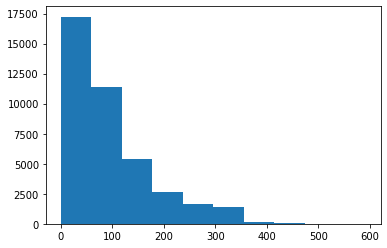

In [0]:
length = []
for i in range(comments_train.shape[0]):
 length.append(len(tokenz.tokenize(comments_train[i])))

plt.hist(length)

On choisit de fixer la longueur de nos commentaires à 128 tokens, principalement par soucis de ressources computationelles et parce que près des deux tiers de nos commentaires respectent cette longueur maximale.

In [0]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 40000


INFO:tensorflow:Writing example 0 of 40000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] joe bid ##en , please ! [SEP]


INFO:tensorflow:tokens: [CLS] joe bid ##en , please ! [SEP]


INFO:tensorflow:input_ids: 101 3533 7226 2368 1010 3531 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3533 7226 2368 1010 3531 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i left teaching before i got in too deep . the principals ' last priorities were the students , and the students ' last priorities were accountability for their ( lack of ) actions . noon ##e seemed to be in charge of academics except bureau ##crats who worked far from any school . as a result , workplace ##s held a constant threat of violence , lack of standards , and helpless ##ness . [SEP]


INFO:tensorflow:tokens: [CLS] i left teaching before i got in too deep . the principals ' last priorities were the students , and the students ' last priorities were accountability for their ( lack of ) actions . noon ##e seemed to be in charge of academics except bureau ##crats who worked far from any school . as a result , workplace ##s held a constant threat of violence , lack of standards , and helpless ##ness . [SEP]


INFO:tensorflow:input_ids: 101 1045 2187 4252 2077 1045 2288 1999 2205 2784 1012 1996 27928 1005 2197 18402 2020 1996 2493 1010 1998 1996 2493 1005 2197 18402 2020 17842 2005 2037 1006 3768 1997 1007 4506 1012 11501 2063 2790 2000 2022 1999 3715 1997 15032 3272 4879 23423 2040 2499 2521 2013 2151 2082 1012 2004 1037 2765 1010 16165 2015 2218 1037 5377 5081 1997 4808 1010 3768 1997 4781 1010 1998 13346 2791 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2187 4252 2077 1045 2288 1999 2205 2784 1012 1996 27928 1005 2197 18402 2020 1996 2493 1010 1998 1996 2493 1005 2197 18402 2020 17842 2005 2037 1006 3768 1997 1007 4506 1012 11501 2063 2790 2000 2022 1999 3715 1997 15032 3272 4879 23423 2040 2499 2521 2013 2151 2082 1012 2004 1037 2765 1010 16165 2015 2218 1037 5377 5081 1997 4808 1010 3768 1997 4781 1010 1998 13346 2791 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] integration psychological ##ly is only possible when understand who we are , where we come from and where we are going ( to para ##ph ##rase ella baker ) . evolution provides part of the story . ivo ##lu ##tion ( the evolution of human self ##con ##sc ##ious ##ness ) completes the picture . there will always be fundamental differences between humans as we evolve or mature in self ##con ##sc ##ious ##ness . e ##war ##rio ##rs will forever be conflict ##ed . the more experienced i ##war ##rio ##rs have better is ##ight ‚ they can see more of the big picture and the whole ##ness and sacred ##ness of all things . they are the peace makers . they do not hate [SEP]


INFO:tensorflow:tokens: [CLS] integration psychological ##ly is only possible when understand who we are , where we come from and where we are going ( to para ##ph ##rase ella baker ) . evolution provides part of the story . ivo ##lu ##tion ( the evolution of human self ##con ##sc ##ious ##ness ) completes the picture . there will always be fundamental differences between humans as we evolve or mature in self ##con ##sc ##ious ##ness . e ##war ##rio ##rs will forever be conflict ##ed . the more experienced i ##war ##rio ##rs have better is ##ight ‚ they can see more of the big picture and the whole ##ness and sacred ##ness of all things . they are the peace makers . they do not hate [SEP]


INFO:tensorflow:input_ids: 101 8346 8317 2135 2003 2069 2825 2043 3305 2040 2057 2024 1010 2073 2057 2272 2013 1998 2073 2057 2024 2183 1006 2000 11498 8458 23797 11713 6243 1007 1012 6622 3640 2112 1997 1996 2466 1012 28346 7630 3508 1006 1996 6622 1997 2529 2969 8663 11020 6313 2791 1007 28123 1996 3861 1012 2045 2097 2467 2022 8050 5966 2090 4286 2004 2057 19852 2030 9677 1999 2969 8663 11020 6313 2791 1012 1041 9028 9488 2869 2097 5091 2022 4736 2098 1012 1996 2062 5281 1045 9028 9488 2869 2031 2488 2003 18743 1522 2027 2064 2156 2062 1997 1996 2502 3861 1998 1996 2878 2791 1998 6730 2791 1997 2035 2477 1012 2027 2024 1996 3521 11153 1012 2027 2079 2025 5223 102


INFO:tensorflow:input_ids: 101 8346 8317 2135 2003 2069 2825 2043 3305 2040 2057 2024 1010 2073 2057 2272 2013 1998 2073 2057 2024 2183 1006 2000 11498 8458 23797 11713 6243 1007 1012 6622 3640 2112 1997 1996 2466 1012 28346 7630 3508 1006 1996 6622 1997 2529 2969 8663 11020 6313 2791 1007 28123 1996 3861 1012 2045 2097 2467 2022 8050 5966 2090 4286 2004 2057 19852 2030 9677 1999 2969 8663 11020 6313 2791 1012 1041 9028 9488 2869 2097 5091 2022 4736 2098 1012 1996 2062 5281 1045 9028 9488 2869 2031 2488 2003 18743 1522 2027 2064 2156 2062 1997 1996 2502 3861 1998 1996 2878 2791 1998 6730 2791 1997 2035 2477 1012 2027 2024 1996 3521 11153 1012 2027 2079 2025 5223 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] love this . . . and her . what a relief that , at last . . . long , long , long last . . . what women have endured is being taken seriously . thank you , nell . . . [SEP]


INFO:tensorflow:tokens: [CLS] love this . . . and her . what a relief that , at last . . . long , long , long last . . . what women have endured is being taken seriously . thank you , nell . . . [SEP]


INFO:tensorflow:input_ids: 101 2293 2023 1012 1012 1012 1998 2014 1012 2054 1037 4335 2008 1010 2012 2197 1012 1012 1012 2146 1010 2146 1010 2146 2197 1012 1012 1012 2054 2308 2031 16753 2003 2108 2579 5667 1012 4067 2017 1010 20970 1012 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2293 2023 1012 1012 1012 1998 2014 1012 2054 1037 4335 2008 1010 2012 2197 1012 1012 1012 2146 1010 2146 1010 2146 2197 1012 1012 1012 2054 2308 2031 16753 2003 2108 2579 5667 1012 4067 2017 1010 20970 1012 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ` ` there is an international community that occasionally can be led by the only real power left in the world , and that ' s the united states , when it suits our interests and when we can get others to go along . ` ` ' ' i confess i had no desire to die in a southeast asian rice paddy . i considered the war in vietnam already lost . ` ` ' ' you do n ' t need to spend tens of millions of dollars on political consultants to tell you what you think when you already know what you think . ` ` ' ' do n ' t get me wrong : i would love to be president . [SEP]


INFO:tensorflow:tokens: [CLS] ` ` there is an international community that occasionally can be led by the only real power left in the world , and that ' s the united states , when it suits our interests and when we can get others to go along . ` ` ' ' i confess i had no desire to die in a southeast asian rice paddy . i considered the war in vietnam already lost . ` ` ' ' you do n ' t need to spend tens of millions of dollars on political consultants to tell you what you think when you already know what you think . ` ` ' ' do n ' t get me wrong : i would love to be president . [SEP]


INFO:tensorflow:input_ids: 101 1036 1036 2045 2003 2019 2248 2451 2008 5681 2064 2022 2419 2011 1996 2069 2613 2373 2187 1999 1996 2088 1010 1998 2008 1005 1055 1996 2142 2163 1010 2043 2009 11072 2256 5426 1998 2043 2057 2064 2131 2500 2000 2175 2247 1012 1036 1036 1005 1005 1045 18766 1045 2018 2053 4792 2000 3280 1999 1037 4643 4004 5785 16063 1012 1045 2641 1996 2162 1999 5148 2525 2439 1012 1036 1036 1005 1005 2017 2079 1050 1005 1056 2342 2000 5247 15295 1997 8817 1997 6363 2006 2576 22283 2000 2425 2017 2054 2017 2228 2043 2017 2525 2113 2054 2017 2228 1012 1036 1036 1005 1005 2079 1050 1005 1056 2131 2033 3308 1024 1045 2052 2293 2000 2022 2343 1012 102


INFO:tensorflow:input_ids: 101 1036 1036 2045 2003 2019 2248 2451 2008 5681 2064 2022 2419 2011 1996 2069 2613 2373 2187 1999 1996 2088 1010 1998 2008 1005 1055 1996 2142 2163 1010 2043 2009 11072 2256 5426 1998 2043 2057 2064 2131 2500 2000 2175 2247 1012 1036 1036 1005 1005 1045 18766 1045 2018 2053 4792 2000 3280 1999 1037 4643 4004 5785 16063 1012 1045 2641 1996 2162 1999 5148 2525 2439 1012 1036 1036 1005 1005 2017 2079 1050 1005 1056 2342 2000 5247 15295 1997 8817 1997 6363 2006 2576 22283 2000 2425 2017 2054 2017 2228 2043 2017 2525 2113 2054 2017 2228 1012 1036 1036 1005 1005 2079 1050 1005 1056 2131 2033 3308 1024 1045 2052 2293 2000 2022 2343 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 40000


INFO:tensorflow:Writing example 10000 of 40000


INFO:tensorflow:Writing example 20000 of 40000


INFO:tensorflow:Writing example 20000 of 40000


INFO:tensorflow:Writing example 30000 of 40000


INFO:tensorflow:Writing example 30000 of 40000


INFO:tensorflow:Writing example 0 of 5000


INFO:tensorflow:Writing example 0 of 5000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] bart ##olo ` ` is there any evidence ' ' yes . hack ##s have been demonstrated possible by experiment , multiple times by multiple independent investigators . there have been counts that just do n ' t make sense , and strongly suggest hacking . it could not be checked because there was no record . would big money attempt to buy power ? where do bears do it ? [SEP]


INFO:tensorflow:tokens: [CLS] bart ##olo ` ` is there any evidence ' ' yes . hack ##s have been demonstrated possible by experiment , multiple times by multiple independent investigators . there have been counts that just do n ' t make sense , and strongly suggest hacking . it could not be checked because there was no record . would big money attempt to buy power ? where do bears do it ? [SEP]


INFO:tensorflow:input_ids: 101 12075 12898 1036 1036 2003 2045 2151 3350 1005 1005 2748 1012 20578 2015 2031 2042 7645 2825 2011 7551 1010 3674 2335 2011 3674 2981 14766 1012 2045 2031 2042 9294 2008 2074 2079 1050 1005 1056 2191 3168 1010 1998 6118 6592 23707 1012 2009 2071 2025 2022 7039 2138 2045 2001 2053 2501 1012 2052 2502 2769 3535 2000 4965 2373 1029 2073 2079 6468 2079 2009 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 12075 12898 1036 1036 2003 2045 2151 3350 1005 1005 2748 1012 20578 2015 2031 2042 7645 2825 2011 7551 1010 3674 2335 2011 3674 2981 14766 1012 2045 2031 2042 9294 2008 2074 2079 1050 1005 1056 2191 3168 1010 1998 6118 6592 23707 1012 2009 2071 2025 2022 7039 2138 2045 2001 2053 2501 1012 2052 2502 2769 3535 2000 4965 2373 1029 2073 2079 6468 2079 2009 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] reagan who did n ' t smoke advertised cigarettes after they were known car ##cino ##gens . this is the go ##p this is america . it will cost our economy big time here in canada but the usa belongs with russia not the western demo ##cr ##acies . [SEP]


INFO:tensorflow:tokens: [CLS] reagan who did n ' t smoke advertised cigarettes after they were known car ##cino ##gens . this is the go ##p this is america . it will cost our economy big time here in canada but the usa belongs with russia not the western demo ##cr ##acies . [SEP]


INFO:tensorflow:input_ids: 101 11531 2040 2106 1050 1005 1056 5610 17099 15001 2044 2027 2020 2124 2482 21081 21230 1012 2023 2003 1996 2175 2361 2023 2003 2637 1012 2009 2097 3465 2256 4610 2502 2051 2182 1999 2710 2021 1996 3915 7460 2007 3607 2025 1996 2530 9703 26775 20499 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 11531 2040 2106 1050 1005 1056 5610 17099 15001 2044 2027 2020 2124 2482 21081 21230 1012 2023 2003 1996 2175 2361 2023 2003 2637 1012 2009 2097 3465 2256 4610 2502 2051 2182 1999 2710 2021 1996 3915 7460 2007 3607 2025 1996 2530 9703 26775 20499 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] congress ' time to ` ` wake up soon ' ' happened long ago . they did n ' t . they , in fact , will be remembered by history as fe ##ckle ##ss and coco ##ns ##pi ##rator ##ial by their complete lack of even comment during this time in the u . s . ' s history . [SEP]


INFO:tensorflow:tokens: [CLS] congress ' time to ` ` wake up soon ' ' happened long ago . they did n ' t . they , in fact , will be remembered by history as fe ##ckle ##ss and coco ##ns ##pi ##rator ##ial by their complete lack of even comment during this time in the u . s . ' s history . [SEP]


INFO:tensorflow:input_ids: 101 3519 1005 2051 2000 1036 1036 5256 2039 2574 1005 1005 3047 2146 3283 1012 2027 2106 1050 1005 1056 1012 2027 1010 1999 2755 1010 2097 2022 4622 2011 2381 2004 10768 19250 4757 1998 25033 3619 8197 16259 4818 2011 2037 3143 3768 1997 2130 7615 2076 2023 2051 1999 1996 1057 1012 1055 1012 1005 1055 2381 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3519 1005 2051 2000 1036 1036 5256 2039 2574 1005 1005 3047 2146 3283 1012 2027 2106 1050 1005 1056 1012 2027 1010 1999 2755 1010 2097 2022 4622 2011 2381 2004 10768 19250 4757 1998 25033 3619 8197 16259 4818 2011 2037 3143 3768 1997 2130 7615 2076 2023 2051 1999 1996 1057 1012 1055 1012 1005 1055 2381 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] as long as republicans in congress allow trump to run the country as his own personal video game that can del ##ete people with the flick of a finger on the keyboard , we ' re in trouble . so obvious that trump is attempting to th ##wart mueller ' s investigation by imp ##ug ##ning the credibility of mcc ##abe and come ##y . donald trump aka dennis the menace . who ' s running the country while trump watches cable news , t ##wee ##ts , and golf ##s ? his sole mission is to bath in the glow of media attention , and anybody who dare ##s stain his image is toast . [SEP]


INFO:tensorflow:tokens: [CLS] as long as republicans in congress allow trump to run the country as his own personal video game that can del ##ete people with the flick of a finger on the keyboard , we ' re in trouble . so obvious that trump is attempting to th ##wart mueller ' s investigation by imp ##ug ##ning the credibility of mcc ##abe and come ##y . donald trump aka dennis the menace . who ' s running the country while trump watches cable news , t ##wee ##ts , and golf ##s ? his sole mission is to bath in the glow of media attention , and anybody who dare ##s stain his image is toast . [SEP]


INFO:tensorflow:input_ids: 101 2004 2146 2004 10643 1999 3519 3499 8398 2000 2448 1996 2406 2004 2010 2219 3167 2678 2208 2008 2064 3972 12870 2111 2007 1996 17312 1997 1037 4344 2006 1996 9019 1010 2057 1005 2128 1999 4390 1012 2061 5793 2008 8398 2003 7161 2000 16215 18367 26774 1005 1055 4812 2011 17727 15916 5582 1996 21553 1997 23680 16336 1998 2272 2100 1012 6221 8398 9875 6877 1996 19854 1012 2040 1005 1055 2770 1996 2406 2096 8398 12197 5830 2739 1010 1056 28394 3215 1010 1998 5439 2015 1029 2010 7082 3260 2003 2000 7198 1999 1996 8652 1997 2865 3086 1010 1998 10334 2040 8108 2015 21101 2010 3746 2003 15174 1012 102 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2004 2146 2004 10643 1999 3519 3499 8398 2000 2448 1996 2406 2004 2010 2219 3167 2678 2208 2008 2064 3972 12870 2111 2007 1996 17312 1997 1037 4344 2006 1996 9019 1010 2057 1005 2128 1999 4390 1012 2061 5793 2008 8398 2003 7161 2000 16215 18367 26774 1005 1055 4812 2011 17727 15916 5582 1996 21553 1997 23680 16336 1998 2272 2100 1012 6221 8398 9875 6877 1996 19854 1012 2040 1005 1055 2770 1996 2406 2096 8398 12197 5830 2739 1010 1056 28394 3215 1010 1998 5439 2015 1029 2010 7082 3260 2003 2000 7198 1999 1996 8652 1997 2865 3086 1010 1998 10334 2040 8108 2015 21101 2010 3746 2003 15174 1012 102 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] wow . i definitely wo n ' t be watching this show . it seems ms . barr , like so many other trump supporters , refuses to believe facts about mr . trump . [SEP]


INFO:tensorflow:tokens: [CLS] wow . i definitely wo n ' t be watching this show . it seems ms . barr , like so many other trump supporters , refuses to believe facts about mr . trump . [SEP]


INFO:tensorflow:input_ids: 101 10166 1012 1045 5791 24185 1050 1005 1056 2022 3666 2023 2265 1012 2009 3849 5796 1012 19820 1010 2066 2061 2116 2060 8398 6793 1010 10220 2000 2903 8866 2055 2720 1012 8398 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 10166 1012 1045 5791 24185 1050 1005 1056 2022 3666 2023 2265 1012 2009 3849 5796 1012 19820 1010 2066 2061 2116 2060 8398 6793 1010 10220 2000 2903 8866 2055 2720 1012 8398 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


## Définition d'un modèle de classification

Maintenant que nos commentaires sont correctement formatés, on peut construire le modèle de classification qui va être exploité.

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

## Paramètres du modèle

In [0]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 10.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
#num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_train_steps = 500
#num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
num_warmup_steps = 50

print("steps par epoque :", num_train_steps)

steps par epoque : 500


## Création du modèle

In [0]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpglvnv_x_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f922fdb25f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpglvnv_x_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f922fdb25f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training

On entraîne notre modèle de BERT sur df_TRAIN_2

On crée ensuite une fonction qui prend en entrée notre ensemble d'apprentissage (train_features) et qui produit un générateur. Il s'agit d'une fonction standard pour pouvoir exploiter les estimateurs de TensorFlow

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

On entraîne notre modèle :

In [0]:
# !!! Très long à exécuter (environ 4h)

# Training 

print(f'Beginning Training!')
print('\n')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('\n')
print("Training took time : ", datetime.now() - current_time)

Beginning Training!


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:loss = 0.6432018, step = 1


INFO:tensorflow:loss = 0.6432018, step = 1


INFO:tensorflow:Saving checkpoints for 20 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 20 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 40 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 40 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 60 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 60 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 80 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 80 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpglvnv_x_/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 0.03275


INFO:tensorflow:global_step/sec: 0.03275


INFO:tensorflow:loss = 0.4900871, step = 101 (3053.486 sec)


INFO:tensorflow:loss = 0.4900871, step = 101 (3053.486 sec)


INFO:tensorflow:Saving checkpoints for 120 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 120 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 140 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 140 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 160 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 160 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 182 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 182 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0337555


INFO:tensorflow:global_step/sec: 0.0337555


INFO:tensorflow:loss = 0.38584125, step = 201 (2962.440 sec)


INFO:tensorflow:loss = 0.38584125, step = 201 (2962.440 sec)


INFO:tensorflow:Saving checkpoints for 204 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 204 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 227 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 227 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 248 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 248 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 269 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 269 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 290 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 290 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0350358


INFO:tensorflow:global_step/sec: 0.0350358


INFO:tensorflow:loss = 0.36795712, step = 301 (2854.235 sec)


INFO:tensorflow:loss = 0.36795712, step = 301 (2854.235 sec)


INFO:tensorflow:Saving checkpoints for 311 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 311 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 332 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 332 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 353 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 353 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 374 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 374 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 396 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 396 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0346269


INFO:tensorflow:global_step/sec: 0.0346269


INFO:tensorflow:loss = 0.20632645, step = 401 (2887.917 sec)


INFO:tensorflow:loss = 0.20632645, step = 401 (2887.917 sec)


INFO:tensorflow:Saving checkpoints for 418 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 418 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 439 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 439 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 460 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 460 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 481 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 481 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpglvnv_x_/model.ckpt.


INFO:tensorflow:Loss for final step: 0.27464232.


INFO:tensorflow:Loss for final step: 0.27464232.




Training took time :  4:05:13.012603


## Testing

On teste sur df_TEST_Trump_2 notre modèle de BERT entraîné.

On évalue ensuite le modèle sur l'ensemble de test :

In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [0]:
# !!! Assez long à exécuter (environ 30 min)

current_time = datetime.now()
estimator.evaluate(input_fn=test_input_fn, steps=None)
print('\n')
print("Testing took time : ", datetime.now() - current_time)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-04-12T10:50:27Z


INFO:tensorflow:Starting evaluation at 2020-04-12T10:50:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /tmp/tmpglvnv_x_/model.ckpt-500


INFO:tensorflow:Restoring parameters from /tmp/tmpglvnv_x_/model.ckpt-500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-04-12-11:17:42


INFO:tensorflow:Finished evaluation at 2020-04-12-11:17:42


INFO:tensorflow:Saving dict for global step 500: auc = 0.84613055, eval_accuracy = 0.853, f1_score = 0.8189209, false_negatives = 397.0, false_positives = 338.0, global_step = 500, loss = 0.3283016, precision = 0.831, recall = 0.807188, true_negatives = 2603.0, true_positives = 1662.0


INFO:tensorflow:Saving dict for global step 500: auc = 0.84613055, eval_accuracy = 0.853, f1_score = 0.8189209, false_negatives = 397.0, false_positives = 338.0, global_step = 500, loss = 0.3283016, precision = 0.831, recall = 0.807188, true_negatives = 2603.0, true_positives = 1662.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /tmp/tmpglvnv_x_/model.ckpt-500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /tmp/tmpglvnv_x_/model.ckpt-500




Testing took time :  0:27:29.455522


Résultats obtenus : Saving dict for global step 500: auc = 0.84613055, eval_accuracy = 0.853, f1_score = 0.8189209, false_negatives = 397.0, false_positives = 338.0, global_step = 500, loss = 0.3283016, precision = 0.831, recall = 0.807188, true_negatives = 2603.0, true_positives = 1662.0


La précision sur notre ensemble de test est de 85% ce qui est une bonne performance !

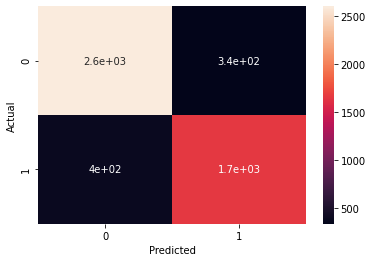

In [0]:
# Matrice de Confusion

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
        'y_Predicted': [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

# On remplace à la main par nos vraies valeurs issues de BERT sur nos Tests :
confusion_matrix[0][0] = 2603 # True_Negatives
confusion_matrix[1][1] = 1662 # True_Positives
confusion_matrix[0][1] = 397 # False_Negatives
confusion_matrix[1][0] = 338 # False_Positives

sn.heatmap(confusion_matrix, annot=True)
plt.show()

#  Évaluation

On veut comparer notre modèle à d'autres modèles (plus simples en géénral) pour rendre compte de ses améliorations.

## Qualitative - Prédictions

On prédit le label sur des phrases et on juge nous-même si le label correspond bien

On réalise ensuite une fonction afin de pouvoir faire des prédictions sur d'autres commentaires 

In [0]:
def getPrediction(in_sentences):
  labels = ["Negative", "Positive"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

On peut tester n'importe quelle phrase en anglais en la mettant dans la liste suivante :

In [0]:
pred_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!"
]

In [0]:
predictions = getPrediction(pred_sentences)
predictions

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] that movie was absolutely awful [SEP]


INFO:tensorflow:tokens: [CLS] that movie was absolutely awful [SEP]


INFO:tensorflow:input_ids: 101 2008 3185 2001 7078 9643 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2008 3185 2001 7078 9643 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the acting was a bit lacking [SEP]


INFO:tensorflow:tokens: [CLS] the acting was a bit lacking [SEP]


INFO:tensorflow:input_ids: 101 1996 3772 2001 1037 2978 11158 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 3772 2001 1037 2978 11158 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the film was creative and surprising [SEP]


INFO:tensorflow:tokens: [CLS] the film was creative and surprising [SEP]


INFO:tensorflow:input_ids: 101 1996 2143 2001 5541 1998 11341 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 2143 2001 5541 1998 11341 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] absolutely fantastic ! [SEP]


INFO:tensorflow:tokens: [CLS] absolutely fantastic ! [SEP]


INFO:tensorflow:input_ids: 101 7078 10392 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 7078 10392 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpglvnv_x_/model.ckpt-500


INFO:tensorflow:Restoring parameters from /tmp/tmpglvnv_x_/model.ckpt-500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


[('That movie was absolutely awful',
  array([-0.01318545, -4.335228  ], dtype=float32),
  'Negative'),
 ('The acting was a bit lacking',
  array([-0.03777353, -3.2949746 ], dtype=float32),
  'Negative'),
 ('The film was creative and surprising',
  array([-0.69802773, -0.68829036], dtype=float32),
  'Positive'),
 ('Absolutely fantastic!',
  array([-4.8109527 , -0.00817347], dtype=float32),
  'Positive')]

## Quantitative - BING

On va comparer nos résultats avec un modèle très simple basé sur le lexique BING.

Explications BING : https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

In [0]:
# Lexique BING
# Importation des deux fichiers NEGATIFS et POSITIFS, contennant les listes des mots connotés comme négatifs et positifs

!wget -O negative-words.txt https://drive.google.com/uc?id=1efaGEdl-lCeTAwrN6NgwWIRZmDqyA5dm
!wget -O positive-words.txt https://drive.google.com/uc?id=1L-emKlpNgJ6IQE5RriByjTOva2F2Birl

words_neg = pd.read_table('/content/negative-words.txt', encoding='latin-1')
words_pos = pd.read_table('/content/positive-words.txt', encoding='latin-1')

--2020-04-12 11:27:29--  https://drive.google.com/uc?id=1efaGEdl-lCeTAwrN6NgwWIRZmDqyA5dm
Resolving drive.google.com (drive.google.com)... 74.125.24.138, 74.125.24.100, 74.125.24.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.24.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c9hmgpn1bor44oida84me086geme248c/1586690775000/08369696792954202122/*/1efaGEdl-lCeTAwrN6NgwWIRZmDqyA5dm [following]
--2020-04-12 11:27:29--  https://doc-0c-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c9hmgpn1bor44oida84me086geme248c/1586690775000/08369696792954202122/*/1efaGEdl-lCeTAwrN6NgwWIRZmDqyA5dm
Resolving doc-0c-94-docs.googleusercontent.com (doc-0c-94-docs.googleusercontent.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to doc-0c-94-docs.googleusercontent.com (doc-0c-94-docs.googleusercontent.com)|172.217.1

In [0]:
# Fonction appliquant le lexique BING

def BING(texte):

  from functools import reduce
  from operator import add
  from spacy.tokenizer import Tokenizer
  from spacy.lang.en import English
  nlp = English()

  ### Tokenization

  # Instanciating the tokenizer
  tokenizer = Tokenizer(nlp.vocab)

  # Repeating the earlier vocabulary count
  arr = texte.drop_duplicates().apply(lambda x: [w.text for w in tokenizer(x)]).array
  arr = reduce(add, arr)
  print("Vocabulary size with Spacy's tokenizer: {}".format(len(set(arr))))
  print('\n')

  # Inspecting a tokenization sample
  tokenization_sample = texte.drop_duplicates().apply(lambda x: 
                                              [w.text for w in tokenizer(x)])
  print("Tokenization sample:\n {}".format(tokenization_sample))


  ### BING 

  scores = []
  for i in range(tokenization_sample.shape[0]) :
    score = 0
    for j in range(len(tokenization_sample.iloc[i])) :
      if str(tokenization_sample.iloc[i][j]) in str(words_neg) :
        score = score-1
      if str(tokenization_sample.iloc[i][j]) in str(words_pos) :
        score = score+1
    scores.append(score)
  

  # 2 labels
  Lab_BING = []
  Lab_BING = [1 if score > 0  # 'positive'
                          else 0 # 'negative'
                                  for score in scores]


  #df_BING = pd.DataFrame(Lab_BING)
  #df_BING.columns = ['label_BING']
  return(Lab_BING)

In [0]:
# On importe à nouveau le Dataframe car l'environnement l'a peut être supprimé pendant l'apprentissage de BERT
df_TEST_Trump_2 = pd.read_csv('/content/df_TEST_Trump_2.csv', delimiter=';')

In [0]:
# !!! Très long à exécuter (environ 1h)

# Application de la fonction BING pour labelliser

current_time = datetime.now()

BING_TEST_Trump = BING(df_TEST_Trump_2.text)

print('\n')
print("Testing took time : ", datetime.now() - current_time)

Vocabulary size with Spacy's tokenizer: 22741


Tokenization sample:
 0       [ , bartolo,  , ``, is, there, any, evidence, ...
1       [ , reagan, who, did, n't, smoke, advertised, ...
2       [ , congress, ', time, to, ``, wake, up, soon,...
3       [ , as, long, as, republicans, in, congress, a...
4       [ , wow, ., i, definitely, wo, n't, be, watchi...
                              ...                        
4995    [ , the, article, reads, as, thought, the, va,...
4996    [ , trump, is, simply, repulsive, ., he, is, e...
4997    [ , this, is, a, good, move, ., if, steel, man...
4998    [ , where, is, the, reasoned, and, rational, u...
4999    [ , unless, and, until, we, can, see, donald, ...
Name: text, Length: 4999, dtype: object


Testing took time :  0:54:34.830541


La cellule suivante indique qu'il y a un soucis de dimensions ici. Cependant, nous n'avons pas réussi à résoudre ce soucis mineur : le dernier commentaire n'est pas labellisé car la taille du "tokenization_sample" est 4999 au lieu de 5000 (indices de 0 à 4999)

In [0]:
print('Nombre de labels avec le lexique AFINN :', len(Labels_Test_Trump_2))
print('Nombre de labels avec le lexique BING :', len(BING_TEST_Trump))

Nombre de labels avec le lexique AFINN : 5000
Nombre de labels avec le lexique BING : 4999


In [0]:
# Creation d'un CSV pour pouvoir relancer la suite sans to run si l'environnement a été reset

df_BING = pd.DataFrame(BING_TEST_Trump)
df_BING.columns = ['label_BING']
df_BING.to_csv('BING_TEST_Trump.csv', sep=';')

# dans les fichiers a gauche, on peut "actualiser" puis "télécharger" les bases 

In [0]:
# Précision de BING

nbre = 0
for i in range(len(BING_TEST_Trump)):
  if BING_TEST_Trump[i] == Labels_Test_Trump_2[i]:
    nbre = nbre + 1

precision_BING = nbre/len(BING_TEST_Trump)
print('BING a une précision de ', precision_BING)

BING a une précision de  0.5577115423084616


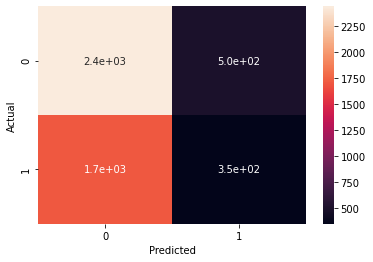

In [0]:
# Matrice de Confusion pour comparer BING aux vrais labels (issus de AFINN)

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual': Labels_Test_Trump_2[0:4999], # on tronque cette liste pour faire correspondre les dimensions
        'y_Predicted': BING_TEST_Trump
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

## Conclusion

On constate que notre modèle basé sur le BERT du Github fournit de bons résultats qualitatifs. En effet, nos prédictions sur de nouvelles phrases semblent cohérentes avec l'interprétation humaine qu'on pourrait en faire.

De plus, notre modèle est plus précis qu'un modèle plus simple (classification avec BING) donc il correpond à une meilleure option de résolution de notre problème de classification. La matrice de confusion semble d'ailleurs assez bonne car il y a peu de faux négatifs ou de faux positifs, ce qui est un critère important pour un outil de classification binaire de sentiments.